In [1]:
import numpy as np
from ReferenceTrajectory import generateTrajectory
from MPC import cftoc
from SystemDynamics import thermoElectricTempControlModel
from PIDControllerSim import PID_Controller
import matplotlib.pyplot as plt

timePoints = [0, 300, 900, 1200, 1800, 2100, 2600, 3000]
TempPoints = [296, 296, 338, 338, 320, 320, 296, 296 ]
x0 = np.ones((1,3))*(23 + 273)
Ts = 5
t,Setpoint = generateTrajectory(timePoints,TempPoints,Ts)

In [2]:
# Simulate PID
Ts = 5.0
Kp = 10.0
Ki = 0.1
Kd = 0.4
temperatureController = PID_Controller(Ts,Kp,Ki,Kd)
temperatureController.setActuatorLimits(-12,12)

x_PID = x0
u_PID = np.zeros((len(t),2))
error_PID = np.zeros((len(t),1))
RSS_error_PID = 0.0

for k in range(len(t)):
    noise = np.random.normal(0.0,1.0,(1,3))
    error_PID[k,0] = Setpoint[k] - x_PID[k,0]
    RSS_error_PID += error_PID[k,0]**2
    u_PID[k,0] = -temperatureController.computeControlInput(error_PID[k,0] + noise[0,0])
    if u_PID[k,0] > 0:
        u_PID[k,1] = u_PID[k,0]/12.0
    else:
        u_PID[k,1] = 0.0
    x_next = thermoElectricTempControlModel(Ts,x_PID[k,:],u_PID[k,:])
    x_PID = np.append(x_PID,x_next,axis=0)

In [4]:
# Simulate MPC
N = 10
Q = np.array([[100, 0, 0], [0, 0, 0], [0, 0, 0]])
R = np.identity(2)
Xl = (273+5)
Xu = (273+150)
Ul = np.array([-12, 0])
Uu = np.array([12, 1])

x_MPC = x0
u_MPC = np.zeros((len(t),2))
x_OL = np.zeros((3,N+1,len(t)))
error_MPC = np.zeros((len(t),1))
RSS_error_MPC = 0.0

for i in range(len(t) - N):
    print(f"MPC Running: {round(i/(len(t) - N) * 100.0,1)} % Complete")
    noise = np.random.normal(0.0,1.0,(1,3))
    error_MPC[i,0] = Setpoint[i] - x_MPC[i,0]
    RSS_error_MPC += error_MPC[i,0]**2
    xref = np.array([Setpoint[i:i+N], Setpoint[i:i+N], Setpoint[i:i+N]])
    model, feas, xOpt, uOpt, JOpt = cftoc(N, Q, R, xref, x_MPC[i,:] + noise[0], Xl, Xu, Ul, Uu)
    x_OL[:,:,i] = xOpt
    u_MPC[i,:] = uOpt[:,0]
    x_next = thermoElectricTempControlModel(Ts,x_MPC[i,:],u_MPC[i,:])
    x_MPC = np.append(x_MPC, x_next, axis = 0)

x_MPC = np.array(x_MPC)
u_MPC = np.array(u_MPC)

MPC Running: 0.0 % Complete


MPC Running: 0.2 % Complete
MPC Running: 0.3 % Complete
MPC Running: 0.5 % Complete
MPC Running: 0.7 % Complete
MPC Running: 0.8 % Complete
MPC Running: 1.0 % Complete
MPC Running: 1.2 % Complete
MPC Running: 1.4 % Complete
MPC Running: 1.5 % Complete
MPC Running: 1.7 % Complete
MPC Running: 1.9 % Complete
MPC Running: 2.0 % Complete
MPC Running: 2.2 % Complete
MPC Running: 2.4 % Complete
MPC Running: 2.5 % Complete
MPC Running: 2.7 % Complete
MPC Running: 2.9 % Complete
MPC Running: 3.0 % Complete
MPC Running: 3.2 % Complete
MPC Running: 3.4 % Complete
MPC Running: 3.6 % Complete
MPC Running: 3.7 % Complete
MPC Running: 3.9 % Complete
MPC Running: 4.1 % Complete
MPC Running: 4.2 % Complete
MPC Running: 4.4 % Complete
MPC Running: 4.6 % Complete
MPC Running: 4.7 % Complete
MPC Running: 4.9 % Complete
MPC Running: 5.1 % Complete
MPC Running: 5.2 % Complete
MPC Running: 5.4 % Complete
MPC Running: 5.6 % Complete
MPC Running: 5.8 % Complete
MPC Running: 5.9 % Complete
MPC Running: 6.1 % C

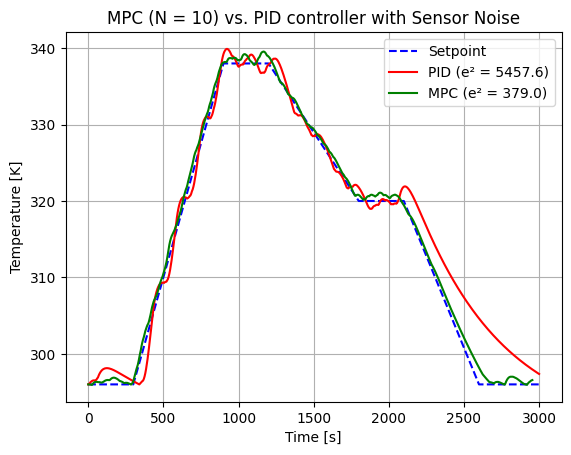

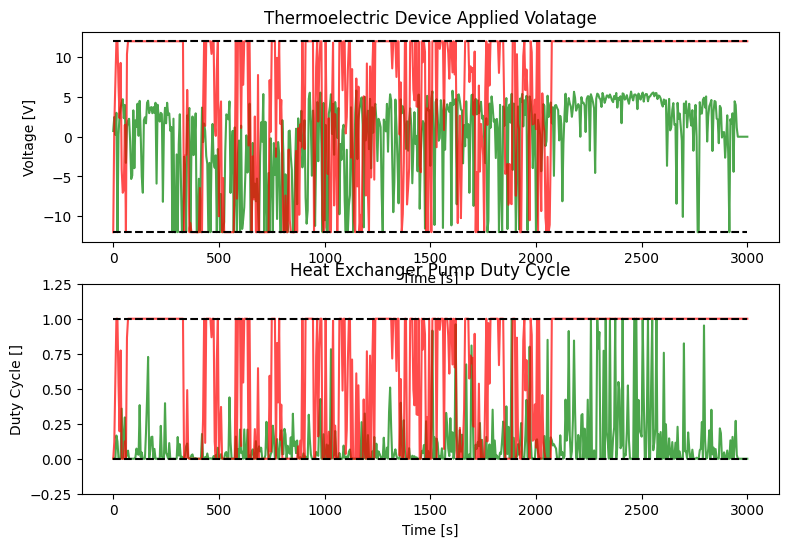

In [21]:
# Plot Outputs
# Temperature vs Time
plt.figure()
plt.plot(t,Setpoint,'b--')
plt.plot(t,x_PID[0:len(t),0],'r')
plt.plot(t[0:len(t) - N + 1],x_MPC[:,0],'g')
plt.grid()
plt.legend([f"Setpoint", f"PID (e\u00b2 = {round(RSS_error_PID,1)})", f"MPC (e\u00b2 = {round(RSS_error_MPC,1)})"])
plt.title(f"MPC (N = {N}) vs. PID controller with Sensor Noise")
plt.xlabel("Time [s]")
plt.ylabel("Temperature [K]")
plt.show()

# Inputs
fig2, (ax1, ax2) = plt.subplots(2,1)
fig2.set_size_inches(9,6)
ax1.plot(t,u_MPC[0:len(t),0],'g',alpha=0.7)
ax1.plot(t,u_PID[0:len(t),0],'r',alpha=0.7)
ax1.plot([t[0], t[-1]], [12, 12], 'k--')
ax1.plot([t[0], t[-1]], [-12, -12], 'k--')
ax1.set(xlabel="Time [s]",ylabel="Voltage [V]", title="Thermoelectric Device Applied Volatage")
plt.ylim([-15,15])
plt.grid()

ax2.plot(t,u_MPC[0:len(t),1],'g',alpha=0.7)
ax2.plot(t,u_PID[0:len(t),1],'r',alpha=0.7)
ax2.plot([t[0], t[-1]], [1, 1], 'k--')
ax2.plot([t[0], t[-1]], [0, 0], 'k--')
ax2.set(xlabel="Time [s]", ylabel="Duty Cycle []", title="Heat Exchanger Pump Duty Cycle")
plt.ylim([-0.25, 1.25])
plt.grid()